In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from docopt import docopt
import os, os.path
import errno

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    average_precision_score, 
    auc
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import (
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    cross_val_predict
)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_curve, auc

from plot_confusion_matrix import plot_confusion_mat
from get_valid_score import mean_std_cross_val_scores

In [2]:
path = "../data/processed"
train_df = pd.read_csv(path+"/bank-additional-train.csv")
test_df = pd.read_csv(path+"/bank-additional-test.csv")

In [3]:
X_train = train_df.drop(columns=["y"])
X_test = test_df.drop(columns=["y"])

y_train = train_df["y"]
y_test = test_df["y"]

In [4]:
train_df.apply(lambda x: pd.unique(x).tolist())

age               [35, 22, 38, 25, 37, 30, 52, 33, 32, 39, 51, 4...
job               [entrepreneur, services, blue-collar, technici...
marital                        [married, single, divorced, unknown]
education         [high.school, professional.course, unknown, ba...
default                                          [no, unknown, yes]
housing                                          [no, yes, unknown]
loan                                             [no, yes, unknown]
contact                                       [telephone, cellular]
month             [may, jul, jun, aug, nov, apr, sep, oct, dec, ...
day_of_week                               [fri, tue, wed, thu, mon]
duration          [178, 256, 42, 442, 107, 1109, 873, 91, 367, 1...
campaign          [2, 3, 5, 4, 8, 1, 10, 6, 12, 13, 20, 11, 7, 2...
pdays             [999, 2, 6, 13, 12, 3, 14, 7, 4, 9, 11, 1, 0, ...
previous                                   [0, 1, 2, 3, 4, 7, 5, 6]
poutcome                            [nonexistent

In [5]:
numeric_features = [
    "age",
    "duration",
    "campaign",
    "pdays",
    "previous",
    "emp.var.rate",
    "cons.price.idx",
    "cons.conf.idx",
    "euribor3m",
    "nr.employed",
]

categorical_features = [
    "job",
    "marital",
    "education",
    "default",
    "housing",
    "loan",
    "contact",
    "month",
    "day_of_week",
    "poutcome",
]

binary_features = [
    "y",
]

drop_features = []
target = "y"

In [6]:
assert len(numeric_features+categorical_features) == len(X_train.columns)

In [7]:
numeric_transformer = make_pipeline(
        SimpleImputer(strategy="median"),
        StandardScaler()
    )

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
    ("drop", drop_features),
)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['age', 'duration', 'campaign', 'pdays',
                                  'previous', 'emp.var.rate', 'cons.price.idx',
                                  'cons.conf.idx', 'euribor3m',
                                  'nr.employed']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                       

In [8]:
results = {}

In [9]:
scoring_metrics = [
    "accuracy",
    "f1",
    "recall",
    "precision",
]

#### Create Dummy Classifier

In [10]:
dummy = DummyClassifier()
pipe = make_pipeline(preprocessor, dummy)

results['dummy'] = mean_std_cross_val_scores(
    pipe, X_train, y_train, cv=5, return_train_score=True, scoring = scoring_metrics
)
pd.DataFrame(results).T

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precis

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
dummy,0.091 (+/- 0.003),0.022 (+/- 0.001),0.888 (+/- 0.000),0.888 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)


#### Confusion Matrix from the Dummy Classifier

C:\MDS\Block 3\DSCI522\lab\Group\Bank_Marketing_Prediction\doc\plot_confusion_matrix.py:51: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[1,1] / sum(conf_mat[:,1])


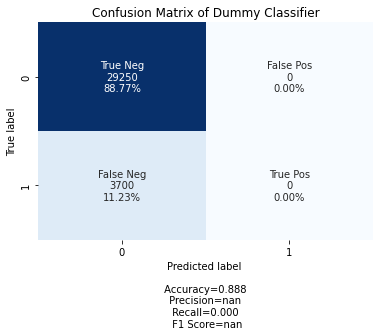

In [11]:
y_pred = cross_val_predict(pipe, X_train, y_train, cv=5)
plot_confusion_mat(y_train, y_pred, 'Dummy Classifier');

### RFC

#### Model building: Tuning Hyperparameters

In [12]:
param_grid = { 
    'RFC__max_features' : ["auto", "sqrt", "log2"],
    'RFC__min_samples_split' : range(1, 100),
    'RFC__max_depth' : range(1,5000),
    'RFC__class_weight' : ["balanced", "balanced_subsample"],
    'RFC__ccp_alpha' : 10**np.arange(-3,3, dtype=float),
}

pipe = Pipeline([
    ('preprocessor',preprocessor), 
    ('RFC',RandomForestClassifier(random_state=123, n_jobs=-1))
])

random_search_RFC = RandomizedSearchCV(estimator=pipe,
                                       param_distributions=param_grid,
                                       n_iter = 20,
                                       n_jobs = -1,
                                       random_state = 123,
                                       return_train_score = True,
                                       scoring = scoring_metrics,
                                       refit = 'f1',
                                      )
random_search_RFC.fit(X_train, y_train);

In [13]:
print("Best hyperparameter values: ", random_search_RFC.best_params_)
print(f"Best f1 score: {random_search_RFC.best_score_:0.3f}")

Best hyperparameter values:  {'RFC__min_samples_split': 88, 'RFC__max_features': 'sqrt', 'RFC__max_depth': 4179, 'RFC__class_weight': 'balanced', 'RFC__ccp_alpha': 0.001}
Best f1 score: 0.551


In [14]:
best_RFC_CV_results = pd.DataFrame(random_search_RFC.cv_results_)[[
'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'params',
       'mean_train_accuracy','std_train_accuracy',
       'mean_train_f1', 'std_train_f1',
       'mean_train_recall', 'std_train_recall',
       'mean_train_precision', 'std_train_precision',
       'mean_test_accuracy','std_test_accuracy', 'rank_test_accuracy',
       'mean_test_f1','std_test_f1', 'rank_test_f1', 
       'mean_test_recall', 'std_test_recall','rank_test_recall', 
       'mean_test_precision','std_test_precision', 'rank_test_precision',
]].set_index("rank_test_f1").sort_index()
best_RFC_CV_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_train_accuracy,std_train_accuracy,mean_train_f1,std_train_f1,mean_train_recall,...,std_test_accuracy,rank_test_accuracy,mean_test_f1,std_test_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_test_precision,std_test_precision,rank_test_precision
rank_test_f1,,,,,,,,,,,,,,,,,,,,,
1,5.291700,0.670314,1.392601,0.725910,"{'RFC__min_samples_split': 88, 'RFC__max_featu...",0.830766,0.001756,0.558214,0.002685,0.952095,...,0.004137,2,0.551348,0.006265,0.938919,0.009494,2,0.390293,0.005971,1
2,4.404900,1.396425,1.770802,1.182728,"{'RFC__min_samples_split': 80, 'RFC__max_featu...",0.829954,0.002209,0.557023,0.003026,0.952027,...,0.002997,3,0.550798,0.004078,0.940270,0.010585,1,0.389506,0.004054,3
3,2.759598,0.880801,1.214602,0.405482,"{'RFC__min_samples_split': 56, 'RFC__max_featu...",0.831214,0.002311,0.557912,0.002969,0.948378,...,0.003668,1,0.550274,0.005794,0.933243,0.008572,3,0.390190,0.005333,2
4,5.190199,0.276574,0.939802,0.140336,"{'RFC__min_samples_split': 47, 'RFC__max_featu...",0.802633,0.007519,0.511406,0.009075,0.919527,...,0.005020,4,0.507827,0.006090,0.914054,0.040618,6,0.351802,0.002679,4
5,4.750698,1.069405,1.303101,0.362993,"{'RFC__min_samples_split': 9, 'RFC__max_featur...",0.802178,0.007224,0.511788,0.006418,0.922905,...,0.010371,5,0.507443,0.010858,0.915676,0.026900,5,0.351206,0.010863,5
6,3.424800,1.126777,3.251603,0.970879,"{'RFC__min_samples_split': 16, 'RFC__max_featu...",0.797018,0.006468,0.508648,0.007584,0.935270,...,0.006557,6,0.505689,0.008437,0.926757,0.028066,4,0.347836,0.006917,6
7,3.593901,0.336085,1.614600,0.379176,"{'RFC__min_samples_split': 85, 'RFC__max_featu...",0.794970,0.007114,0.466926,0.017815,0.801824,...,0.009731,7,0.465216,0.011883,0.801351,0.069502,9,0.328492,0.005351,7
8,4.317999,0.545212,0.945203,0.365715,"{'RFC__min_samples_split': 64, 'RFC__max_featu...",0.747269,0.030642,0.440918,0.042843,0.880676,...,0.032807,8,0.439170,0.046777,0.879189,0.059322,7,0.293152,0.036568,8
9,5.898001,0.382759,1.039602,0.209198,"{'RFC__min_samples_split': 18, 'RFC__max_featu...",0.717284,0.016110,0.407319,0.021329,0.864662,...,0.018370,10,0.404782,0.021640,0.861081,0.054722,8,0.264794,0.015213,10


In [15]:
best_RFC_params = {key.replace('RFC__',''):val for (key, val) in random_search_RFC.best_params_.items()}
best_RFC_params['random_state']=123
best_RFC_params['n_jobs']=-1
best_RFC_params

{'min_samples_split': 88,
 'max_features': 'sqrt',
 'max_depth': 4179,
 'class_weight': 'balanced',
 'ccp_alpha': 0.001,
 'random_state': 123,
 'n_jobs': -1}

In [16]:
best_RFC = pipe = Pipeline([
    ('preprocessor',preprocessor), 
    ('RFC',RandomForestClassifier(**best_RFC_params))
])

best_RFC.fit(X_train, y_train)
best_RFC.score(X_train, y_train)

0.8272230652503794

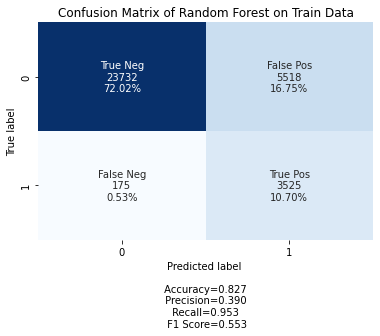

In [17]:
y_pred = best_RFC.predict(X_train)
plot_confusion_mat(y_train, y_pred,'Random Forest on Train Data');

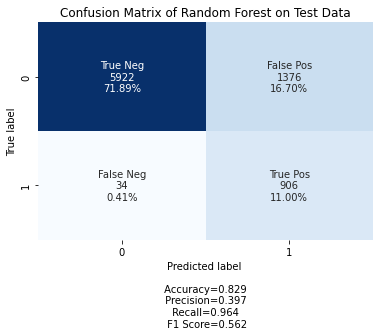

In [18]:
y_pred = best_RFC.predict(X_test)
plot_confusion_mat(y_test, y_pred,'Random Forest on Test Data');

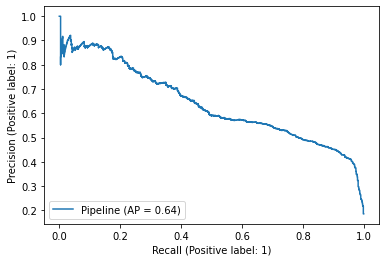

In [19]:
PrecisionRecallDisplay.from_estimator(best_RFC, X_test, y_test);

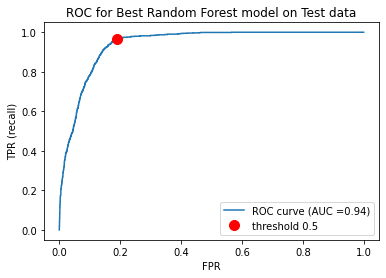

In [20]:
y_pred = best_RFC.predict_proba(X_test)[:,1] 

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (AUC ={0:.2f})'.format(roc_auc))
plt.title("ROC for Best Random Forest model on Test data")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

default_threshold = np.argmin(np.abs(thresholds - 0.5))

plt.plot(
    fpr[default_threshold],
    tpr[default_threshold],
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best");

### LR

#### Model building: Tuning Hyperparameters

In [21]:
param_grid = { 
    'LR__C' : np.linspace(1,50,100),
    'LR__class_weight' : ["balanced", None],
}

pipe_lr = Pipeline([
    ('preprocessor',preprocessor), 
    ('LR',LogisticRegression(max_iter=1000, random_state=123))
])

random_search_LR = RandomizedSearchCV(estimator=pipe_lr,
                                       param_distributions=param_grid,
                                       n_jobs = -1,
                                       random_state = 123,
                                       return_train_score = True,
                                       scoring = scoring_metrics,
                                       refit = 'f1',
                                      )
random_search_LR.fit(X_train, y_train);

In [22]:
print("Best hyperparameter values: ", random_search_LR.best_params_)
print(f"Best f1 score: {random_search_LR.best_score_:0.3f}")

Best hyperparameter values:  {'LR__class_weight': 'balanced', 'LR__C': 26.737373737373737}
Best f1 score: 0.585


In [23]:
best_LR_CV_results = pd.DataFrame(random_search_LR.cv_results_)[[
'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'params',
       'mean_train_accuracy','std_train_accuracy',
       'mean_train_f1', 'std_train_f1',
       'mean_train_recall', 'std_train_recall',
       'mean_train_precision', 'std_train_precision',
       'mean_test_accuracy','std_test_accuracy', 'rank_test_accuracy',
       'mean_test_f1','std_test_f1', 'rank_test_f1', 
       'mean_test_recall', 'std_test_recall','rank_test_recall', 
       'mean_test_precision','std_test_precision', 'rank_test_precision',
]].set_index("rank_test_f1").sort_index()
best_LR_CV_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_train_accuracy,std_train_accuracy,mean_train_f1,std_train_f1,mean_train_recall,...,std_test_accuracy,rank_test_accuracy,mean_test_f1,std_test_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_test_precision,std_test_precision,rank_test_precision
rank_test_f1,,,,,,,,,,,,,,,,,,,,,
1,5.725600,2.073001,0.140502,0.147349,"{'LR__class_weight': 'balanced', 'LR__C': 26.7...",0.860220,0.001242,0.587166,0.002407,0.885203,...,0.005398,7,0.584670,0.010554,0.881351,0.014388,1,0.437517,0.010362,7
1,5.201799,1.535438,0.054600,0.021752,"{'LR__class_weight': 'balanced', 'LR__C': 41.0...",0.860182,0.001243,0.587101,0.002421,0.885203,...,0.005398,7,0.584670,0.010554,0.881351,0.014388,1,0.437517,0.010362,7
1,4.317599,0.459601,0.041700,0.009739,"{'LR__class_weight': 'balanced', 'LR__C': 40.1...",0.860182,0.001238,0.587100,0.002411,0.885203,...,0.005398,7,0.584670,0.010554,0.881351,0.014388,1,0.437517,0.010362,7
4,5.547102,2.562749,0.101999,0.049096,"{'LR__class_weight': 'balanced', 'LR__C': 13.3...",0.860190,0.001178,0.587113,0.002286,0.885203,...,0.005353,10,0.584562,0.010505,0.881351,0.014388,1,0.437395,0.010275,10
5,12.571799,3.439493,0.078799,0.031682,"{'LR__class_weight': None, 'LR__C': 9.90909090...",0.911115,0.000636,0.516794,0.004582,0.423311,...,0.001348,3,0.515920,0.005919,0.424054,0.008857,5,0.659104,0.013393,1
6,5.202502,1.290630,0.067400,0.011809,"{'LR__class_weight': None, 'LR__C': 32.1818181...",0.911131,0.000615,0.516835,0.004649,0.423311,...,0.001296,1,0.515908,0.006255,0.424054,0.009571,5,0.659101,0.013042,2
6,6.477901,2.279240,0.068601,0.007777,"{'LR__class_weight': None, 'LR__C': 45.0505050...",0.911115,0.000627,0.516753,0.004651,0.423243,...,0.001296,1,0.515908,0.006255,0.424054,0.009571,5,0.659101,0.013042,2
8,7.968798,2.354879,0.040900,0.016656,"{'LR__class_weight': None, 'LR__C': 13.8686868...",0.911123,0.000631,0.516815,0.004648,0.423311,...,0.001344,4,0.515669,0.006267,0.423784,0.009308,8,0.658957,0.013289,4
9,6.893900,1.601183,0.062700,0.003828,"{'LR__class_weight': None, 'LR__C': 37.6262626...",0.911115,0.000628,0.516794,0.004638,0.423311,...,0.001316,4,0.515665,0.006351,0.423784,0.009578,8,0.658957,0.013130,5


In [24]:
pd.DataFrame(random_search_LR.cv_results_).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_LR__class_weight', 'param_LR__C', 'params',
       'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy',
       'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy',
       'std_test_accuracy', 'rank_test_accuracy', 'split0_train_accuracy',
       'split1_train_accuracy', 'split2_train_accuracy',
       'split3_train_accuracy', 'split4_train_accuracy', 'mean_train_accuracy',
       'std_train_accuracy', 'split0_test_f1', 'split1_test_f1',
       'split2_test_f1', 'split3_test_f1', 'split4_test_f1', 'mean_test_f1',
       'std_test_f1', 'rank_test_f1', 'split0_train_f1', 'split1_train_f1',
       'split2_train_f1', 'split3_train_f1', 'split4_train_f1',
       'mean_train_f1', 'std_train_f1', 'split0_test_recall',
       'split1_test_recall', 'split2_test_recall', 'split3_test_recall',
       'split4_test_recall', 'mean_test_recall', 'std_test_recall',
       'rank

Text(0.5, 1.0, 'Logistic Regression C vs Accuracy')

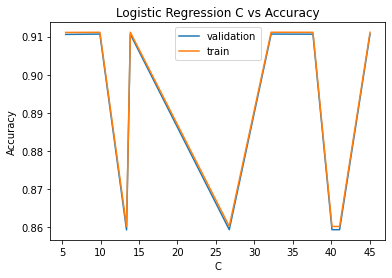

In [25]:
# Save C vs Accuracy plot
search_df = pd.DataFrame(random_search_LR.cv_results_).sort_values(by="param_LR__C", ascending=True)
plt.plot(search_df["param_LR__C"], search_df["mean_test_accuracy"], label="validation")
plt.plot(search_df["param_LR__C"], search_df["mean_train_accuracy"], label="train")
plt.legend()
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title('Logistic Regression C vs Accuracy')
#plt.savefig(dest+'/Log_Reg_C_vs_Accuracy.png')

In [26]:
best_LR_params = {key.replace('LR__',''):val for (key, val) in random_search_LR.best_params_.items()}
best_LR_params['random_state']=123
best_LR_params['max_iter']=1000
best_LR_params

{'class_weight': 'balanced',
 'C': 26.737373737373737,
 'random_state': 123,
 'max_iter': 1000}

In [27]:
best_LR = Pipeline([
    ('preprocessor',preprocessor), 
    ('LR',LogisticRegression(**best_LR_params))
])
best_LR.fit(X_train, y_train)
best_LR.score(X_train, y_train)

0.860030349013657

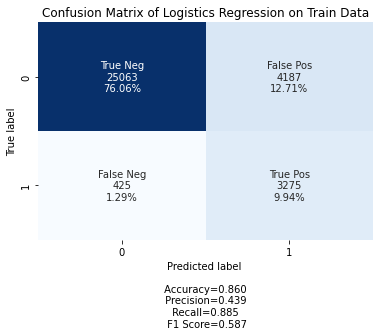

In [28]:
y_pred = best_LR.predict(X_train)
plot_confusion_mat(y_train, y_pred,'Logistics Regression on Train Data');

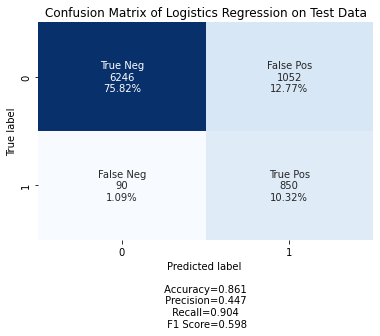

In [29]:
y_pred = best_LR.predict(X_test)
plot_confusion_mat(y_test, y_pred,'Logistics Regression on Test Data');

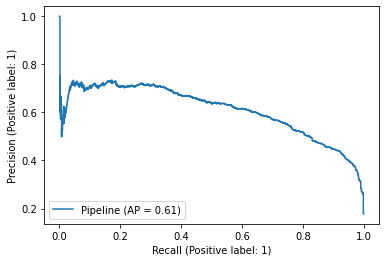

In [30]:
PrecisionRecallDisplay.from_estimator(best_LR, X_test, y_test);

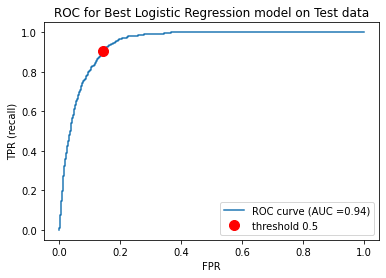

In [31]:
y_pred = best_LR.predict_proba(X_test)[:,1] 

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (AUC ={0:.2f})'.format(roc_auc))
plt.title("ROC for Best Logistic Regression model on Test data")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

default_threshold = np.argmin(np.abs(thresholds - 0.5))

plt.plot(
    fpr[default_threshold],
    tpr[default_threshold],
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best");

In [32]:
categorical_features_ohe = list(
    preprocessor.named_transformers_["pipeline-2"]
    .named_steps["onehotencoder"]
    .get_feature_names_out(categorical_features)
)
new_columns = (
    numeric_features + categorical_features_ohe
)

In [33]:
lr_coefs = pd.DataFrame(data=best_LR[1].coef_[0], index=new_columns, columns=["Coefficient"])
lr_coefs.sort_values(by="Coefficient", ascending=False).head(20)

,Coefficient
duration,1.802879
month_mar,1.801102
cons.price.idx,1.278377
euribor3m,1.248291
month_aug,0.867557
education_illiterate,0.756399
job_retired,0.376642
poutcome_success,0.371156
job_student,0.328776
month_sep,0.202494
